# **League of Legends - Match Outcome Prediction**

Predicting Match Outcomes Using the First 10 Minutes of Gameplay Data in Diamond Rank

In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/포트폴리오 데이터 분석 실습/LOL Match Prediction/data')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/포트폴리오 데이터 분석 실습/LOL Match Prediction/data'

# **Problem Definition**

1. Finding out the key factors that influence victory and analyze their correlations.

    *   Does First Blood influcence the winning rate?
    *   Is there relationship between gold difference and win rate?
    *   How important is objective control (Dragons, Herald) for winning?
    *   Is there correlation between KDA and win rate?
    *   Correlation between key factors. (GoldDiff, ExperienceDiff, Kills, KDA, EliteMosters)

2. Predict match outcomes using machine learning models.

# **Data Preprocessing**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from lightgbm import LGBMClassifier

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load Data
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

df = pd.read_csv('high_diamond_ranked_10min.csv')
print(f'Data Shape: {df.shape}')
df.head()

Data Shape: (9879, 40)


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [4]:
# Target: Blue Wins

print('Target Distribution:')
print(df['blueWins'].value_counts())
print(f'Blue Team Win Rate: {round(df['blueWins'].mean()*100, 2)}%')

Target Distribution:
blueWins
0    4949
1    4930
Name: count, dtype: int64
Blue Team Win Rate: 49.9%


In [5]:
df.info()

# There is no missing value.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [6]:
# Remove 'gameID' column
df = df.drop('gameId', axis=1)

# Add columns 'blueKDA' and 'blueKillDiff'
df['blueKDA'] = (df['blueKills'] + df['blueAssists']) / df['blueDeaths'].replace(0, 1)
df['blueKillDiff'] = df['blueKills'] - df['redKills']

print(f'Final Data Shape: {df.shape}')

Final Data Shape: (9879, 41)


# **EDA (Exploratory Data Analysis)**

## ▶ Does First Blood influence the winning rate?

In [7]:
# First Blood Win Rate
fb_winrate = df.groupby('blueFirstBlood')['blueWins'].mean() * 100
fb_winrate

,blueWins
blueFirstBlood,
0,39.717907
1,59.895729


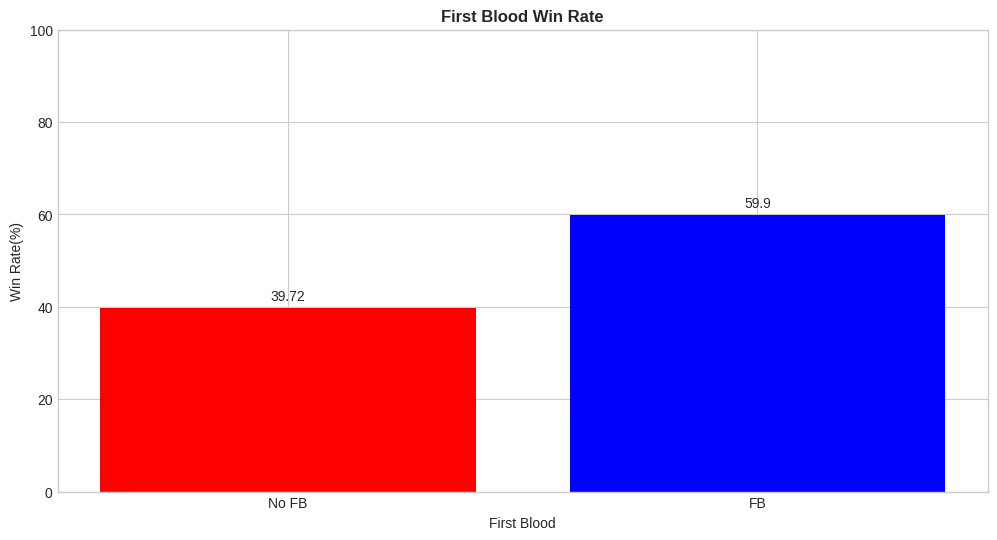

In [8]:
plt.bar(fb_winrate.index, fb_winrate.values, color=['red', 'blue'])
plt.xticks(fb_winrate.index, ['No FB', 'FB'])
plt.xlabel('First Blood')
plt.ylabel('Win Rate(%)')
plt.ylim(0, 100)
plt.title('First Blood Win Rate', fontweight='bold')

for i, v in enumerate(fb_winrate):
  plt.text(i, v+1, round(v, 2), ha='center', va='bottom')

plt.show()

The graph shows a meaningful difference in win rate. Securing First Blood increases the chance of winning the game by approximately 20%.

## ▶ Is there relationship between gold difference and win rate?

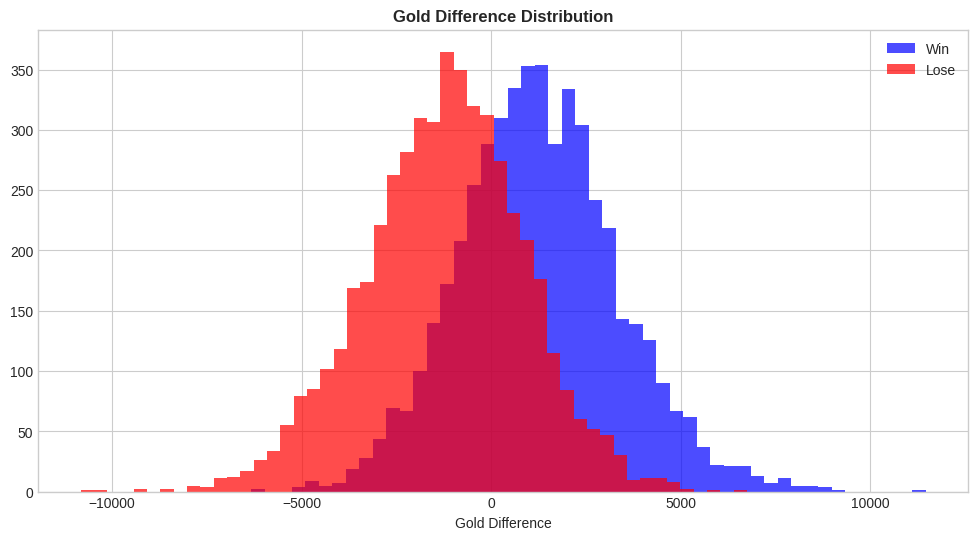

In [9]:
# Gold Difference Win Rate
plt.hist(df[df['blueWins']==1]['blueGoldDiff'], bins=50, alpha=0.7, label='Win', color='blue')
plt.hist(df[df['blueWins']==0]['blueGoldDiff'], bins=50, alpha=0.7, label='Lose', color='red')
plt.xlabel('Gold Difference')
plt.title('Gold Difference Distribution', fontweight='bold')
plt.legend()
plt.show()

Winning teams tends to have a positive gold difference, while losing teams are are centered around negative gold differences.

There is a significant overlap around zero gold difference, indicating that small gold advantages (approximate range between -1000 < x < +1000) do not guarantee victory. Extreme gold differences show clear separation, where large positive gold lead to wins and large negative gold leads to losses.

## ▶ How important is objective control (Dragons, Herald) for winning?

In [10]:
# Objective Control Win Rate
ob_winrate = df.groupby('blueEliteMonsters')['blueWins'].mean()*100
ob_winrate

,blueWins
blueEliteMonsters,
0,39.856478
1,58.634438
2,73.521127


In [11]:
dragon_winrate = df.groupby('blueDragons')['blueWins'].mean()*100
dragon_winrate

,blueWins
blueDragons,
0,41.853086
1,64.093960


In [12]:
heralds_winrate = df.groupby('blueHeralds')['blueWins'].mean()*100
heralds_winrate

,blueWins
blueHeralds,
0,47.681376
1,59.504577


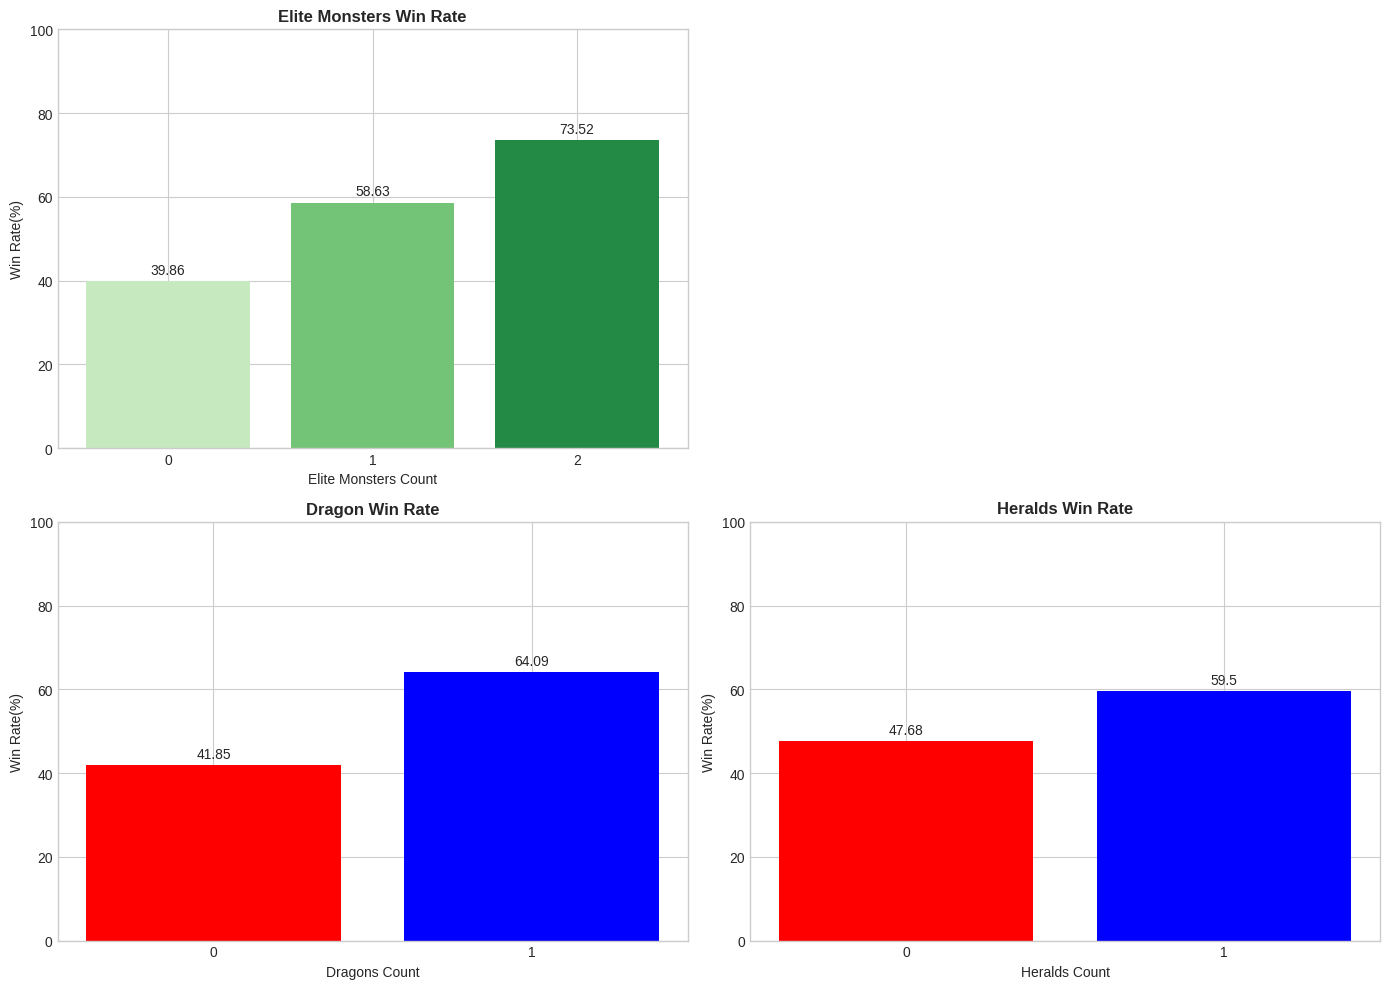

In [13]:
fig = plt.figure(figsize=(14, 10))
colors = ['red', 'blue']

plt.subplot(2, 2, 1)
plt.bar(ob_winrate.index, ob_winrate.values, color=sns.color_palette('Greens', n_colors=len(ob_winrate.index)))
plt.xticks(ob_winrate.index, [0, 1, 2])
plt.xlabel('Elite Monsters Count')
plt.ylabel('Win Rate(%)')
plt.ylim(0, 100)
plt.title('Elite Monsters Win Rate', fontweight='bold')
for i, v in enumerate(ob_winrate):
  plt.text(i, v+1, round(v, 2), ha='center', va='bottom')

plt.subplot(2, 2, 3)
plt.bar(dragon_winrate.index, dragon_winrate.values, color=colors)
plt.xticks(dragon_winrate.index, [0, 1])
plt.xlabel('Dragons Count')
plt.ylabel('Win Rate(%)')
plt.ylim(0, 100)
plt.title('Dragon Win Rate', fontweight='bold')
for i, v in enumerate(dragon_winrate):
  plt.text(i, v+1, round(v, 2), ha='center', va='bottom')

plt.subplot(2, 2, 4)
plt.bar(heralds_winrate.index, heralds_winrate.values, color=colors)
plt.xticks(heralds_winrate.index, [0, 1])
plt.xlabel('Heralds Count')
plt.ylabel('Win Rate(%)')
plt.ylim(0, 100)
plt.title('Heralds Win Rate', fontweight='bold')
for i, v in enumerate(heralds_winrate):
  plt.text(i, v+1, round(v, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

The graphs above indicate that objective control can affect match outcomes. As more elite monsters are secured, the chance of winning increases significantly. However, since this data reflects only the first 10 minutes of the game, it is rare to obtain both the Dragon and the Herald. Securing a Dragon increases the win rate by approximately 22%, while securing a Herald increases it by about 12%. Therefore, if a team must choose between the two elite monsters, prioritizing the Dragon is more reliable than taking the Herald.

## ▶ Is there correlation between KDA and win rate?

,blueKDA
count,9879.000000
mean,2.897621
std,3.013895
min,0.000000
25%,1.200000
50%,2.000000
75%,3.500000
max,40.000000


,blueWins
blueKDA_bin,
"(-0.001, 1.0]",18.048780
"(1.0, 1.7]",35.170604
"(1.7, 2.5]",50.963391
"(2.5, 4.0]",65.433925
"(4.0, 40.0]",82.692308


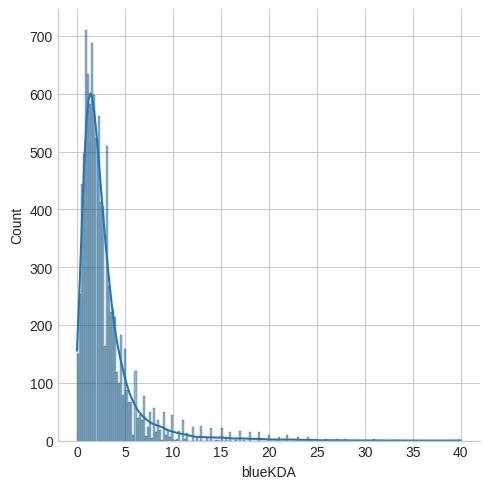

In [14]:
# KDA Win Rate

display(pd.DataFrame(df['blueKDA'].describe()))

df['blueKDA_bin'] = pd.qcut(df['blueKDA'], q=5)
kda_winrate = df.groupby('blueKDA_bin')['blueWins'].mean()*100
display(kda_winrate)

sns.displot(df['blueKDA'], kde=True)

The histogram is skewed to the left, indicating that it is rare to have a high KDA within the first 10 minutes of the game. The most common KDA value is approximately 1.0. According to the table, a KDA between 1 and 2 does not guarantee victory. However, when the KDA exceeds 2.5, the win rate clearly increases to 65% or higher.

## ▶ Correlation between key factors. (GoldDiff, ExperienceDiff, Kills, KDA, EliteMosters)

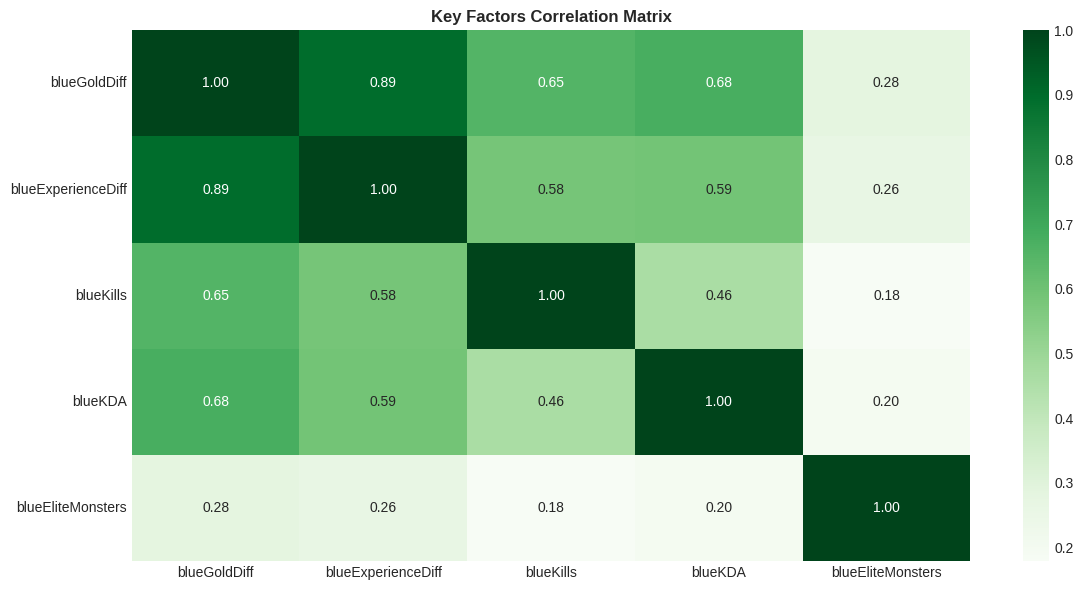

In [15]:
# Correlation between key factors (GoldDiff, ExperienceDiff, Kills, KDA, EliteMosters)
key_factors = ['blueGoldDiff', 'blueExperienceDiff', 'blueKills', 'blueKDA', 'blueEliteMonsters']
sns.heatmap(df[key_factors].corr(), annot=True, fmt='.2f', cmap='Greens')
plt.title('Key Factors Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

Gold difference and experience difference show a very strong correlation. During lane dominance, teams tend to secure gold and experience simultaneously, which explains the strong relationship between these two variables.

Kills and KDA also exhibit a relatively strong positive correlation with gold difference. An increase in kills directly results in additional gold gains. Since KDA accounts for death counts, fewer deaths increase the likelihood of continuously securing gold without interruptions.

Elite monsters show a positive correlation with gold difference, but the strength of this relationship is weaker compared to other features. This suggests that securing elite monsters does not directly determine match outcomes; rather, it functions as an indirect factor that contributes to gold advantage.

# **Model Training**

In [16]:
df.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,blueKDA,blueKillDiff,blueKDA_bin
0,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7,3.333333,3,"(2.5, 4.0]"
1,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0,2.000000,0,"(1.7, 2.5]"
2,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5,1.000000,-4,"(-0.001, 1.0]"
3,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1,1515.7,15,2,1,5,4,10,0,0,0,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8,1.800000,-1,"(1.7, 2.5]"
4,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0,1640.0,17,2,1,6,6,7,1,1,0,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4,2.000000,0,"(1.7, 2.5]"


In [17]:
variables = ['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueGoldDiff', 'blueExperienceDiff', 'blueCSPerMin',
             'blueKDA', 'blueKillDiff']

X = df[variables]
Y = df['blueWins']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=1234)

print(x_train.shape)
print(y_train.shape)
print('')
print(x_test.shape)
print(y_test.shape)

(6915, 11)
(6915,)

(2964, 11)
(2964,)


Our target variable is ***blueWins***.

Based on the EDA, several feature variables expected to affect match outcomes were selected, including **blueFirstBlood**, **blueDragons**, **blueHeralds**, **blueGoldDiff**, **blueExperienceDiff**, **blueKDA**, and **blueKillDiff**.

Other variables such as **blueWardsPlaced**, **blueWardsDestroyed**, **blueTowersDestroyed**, and **blueCSPerMin** were selected, as they may serve as meaningful features but represent more indirect factors.

For the machine learning models, the datasets was randomly split into traning and test sets using 70:30 ratio.

## ▶ Logistic Regression

In [18]:
# Scaling
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

LR = LogisticRegression()
LR.fit(x_train_sc, y_train)

LogisticRegression()

In [19]:
y_pred_train = LR.predict(x_train_sc)
y_pred_test = LR.predict(x_test_sc)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      3464
           1       0.73      0.73      0.73      3451

    accuracy                           0.73      6915
   macro avg       0.73      0.73      0.73      6915
weighted avg       0.73      0.73      0.73      6915

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1485
           1       0.74      0.74      0.74      1479

    accuracy                           0.74      2964
   macro avg       0.74      0.74      0.74      2964
weighted avg       0.74      0.74      0.74      2964



In [20]:
# Prediction
y_pred_train_proba = LR.predict_proba(x_train_sc)[:, 1]
y_pred_test_proba = LR.predict_proba(x_test_sc)[:, 1]

roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)
roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

print('roc_score_train: ', roc_auc_train)
print('roc_score_test: ', roc_auc_test)

roc_score_train:  0.8094896515586407
roc_score_test:  0.8117560550285363


In [21]:
df_comparison = pd.DataFrame(columns=['model', 'f1_train', 'f1_test', 'AUC_train', 'AUC_test'])
df_comparison

,model,f1_train,f1_test,AUC_train,AUC_test


In [22]:
# Performance
lr_re = pd.DataFrame({'model' : ['LR'],
                      'f1_train' : f1_score(y_train, y_pred_train),
                      'f1_test' : f1_score(y_test, y_pred_test),
                      'AUC_train' : roc_auc_score(y_train, y_pred_train_proba),
                      'AUC_test' : roc_auc_score(y_test, y_pred_test_proba)})

df_comparison = pd.concat([df_comparison, lr_re])
df_comparison

,model,f1_train,f1_test,AUC_train,AUC_test
0,LR,0.727668,0.738969,0.80949,0.811756


In [23]:
# Feature Importance: coef, p-value
x_train_sm = sm.add_constant(x_train_sc)
result = sm.Logit(y_train, x_train_sm).fit()

pval_df = pd.DataFrame({'feature' : ['const'] + list(x_train.columns),
                        'coef' : result.params,
                        'p_value' : result.pvalues})

pval_df = pval_df[pval_df['feature'] != 'const']
pval_df['abs_coef'] = pval_df['coef'].abs()
pval_df = pval_df.sort_values('abs_coef', ascending=False)
pval_df

Optimization terminated successfully.
         Current function value: 0.529998
         Iterations 6


,feature,coef,p_value,abs_coef
x7,blueGoldDiff,0.960162,1.505434e-18,0.960162
x8,blueExperienceDiff,0.512364,6.185612e-14,0.512364
x4,blueDragons,0.255935,9.336043e-19,0.255935
x11,blueKillDiff,-0.092756,3.038147e-01,0.092756
x10,blueKDA,0.076121,2.143402e-01,0.076121
x3,blueFirstBlood,0.068048,2.765197e-02,0.068048
x5,blueHeralds,0.037297,2.053426e-01,0.037297
x6,blueTowersDestroyed,-0.033254,3.873197e-01,0.033254
x2,blueWardsDestroyed,-0.027388,3.459189e-01,0.027388
x1,blueWardsPlaced,-0.023638,4.075274e-01,0.023638


## ▶ Random Forest

In [24]:
# Prediction
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3464
           1       1.00      1.00      1.00      3451

    accuracy                           1.00      6915
   macro avg       1.00      1.00      1.00      6915
weighted avg       1.00      1.00      1.00      6915

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1485
           1       0.73      0.72      0.72      1479

    accuracy                           0.73      2964
   macro avg       0.73      0.73      0.73      2964
weighted avg       0.73      0.73      0.73      2964



In [25]:
y_pred_train_proba = rfc.predict_proba(x_train)[:, 1]
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1]

roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print('roc_score_train: ', roc_score_train)
print('roc_score_test: ', roc_score_test)

roc_score_train:  1.0
roc_score_test:  0.7966156949253638


In [26]:
# Overfitting is observed => Use BO to lower overfitting
!pip install bayesian-optimization

In [27]:
from bayes_opt import BayesianOptimization

def model_evaluate(n_estimators, max_depth):
  clf = RandomForestClassifier(
      n_estimators = int(n_estimators),
      max_depth = int(max_depth))
  scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='roc_auc')
  return np.mean(scores)

def bayesOpt(x_train, y_train):
  clfBO = BayesianOptimization(model_evaluate, {'n_estimators':(100, 600),
                                                'max_depth':(5, 20)})
  clfBO.maximize(init_points=5, n_iter=10)
  print(clfBO.res)

bayesOpt(x_train, y_train)

|   iter    |  target   | n_esti... | max_depth |
-------------------------------------------------
| 1         | 0.8027167 | 340.12618 | 11.173963 |
| 2         | 0.8054354 | 205.65027 | 6.2031277 |
| 3         | 0.8053844 | 558.30181 | 6.8875636 |
| 4         | 0.8040752 | 268.83102 | 9.4610589 |
| 5         | 0.8053606 | 473.41625 | 5.4675358 |
| 6         | 0.8050895 | 207.11844 | 6.4304458 |
| 7         | 0.8058725 | 198.62709 | 6.0798747 |
| 8         | 0.7971938 | 198.22141 | 16.439444 |
| 9         | 0.7992360 | 562.37553 | 15.648236 |
| 10        | 0.8052309 | 551.47923 | 5.0       |
| 11        | 0.8043877 | 481.10626 | 9.4438268 |
| 12        | 0.8009630 | 470.59329 | 13.726067 |
| 13        | 0.8054689 | 192.07479 | 5.0       |
| 14        | 0.8052673 | 183.90608 | 5.4699797 |
| 15        | 0.8049544 | 174.63946 | 6.3861629 |
[{'target': np.float64(0.8027167743542531), 'params': {'n_estimators': np.float64(340.1261821271816), 'max_depth': np.float64(11.173963041661258)}}, {

In [28]:
# Hyperparameter Tuning
rfc = RandomForestClassifier(n_estimators=199, max_depth=6)
rfc.fit(x_train, y_train)

y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

y_pred_train_proba = rfc.predict_proba(x_train)[:, 1]
y_pred_test_proba = rfc.predict_proba(x_test)[:, 1]

# Performance
rfc_re = pd.DataFrame({'model' : ['RF(BO)'],
                       'f1_train' : f1_score(y_train, y_pred_train),
                       'f1_test' : f1_score(y_test, y_pred_test),
                       'AUC_train' : roc_auc_score(y_train, y_pred_train_proba),
                       'AUC_test' : roc_auc_score(y_test, y_pred_test_proba)})

df_comparison = pd.concat([df_comparison, rfc_re])
df_comparison

,model,f1_train,f1_test,AUC_train,AUC_test
0,LR,0.727668,0.738969,0.809490,0.811756
0,RF(BO),0.745035,0.733106,0.833478,0.809386


In [29]:
# Feature Importance
rfc_importance = pd.DataFrame({'feature' : x_train.columns,
                              'importance' : rfc.feature_importances_})
rfc_importance = rfc_importance.sort_values('importance', ascending=False)
rfc_importance

,feature,importance
6,blueGoldDiff,0.366259
7,blueExperienceDiff,0.242284
10,blueKillDiff,0.160306
9,blueKDA,0.121025
3,blueDragons,0.031155
8,blueCSPerMin,0.028390
0,blueWardsPlaced,0.017672
2,blueFirstBlood,0.016254
1,blueWardsDestroyed,0.009866
5,blueTowersDestroyed,0.003491


## ▶ LightGBM

In [30]:
LGBM = LGBMClassifier(verbose=-1)
LGBM.fit(x_train, y_train)

LGBMClassifier(verbose=-1)

In [31]:
# Prediction
y_pred_train = LGBM.predict(x_train)
y_pred_test = LGBM.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3464
           1       0.84      0.82      0.83      3451

    accuracy                           0.83      6915
   macro avg       0.83      0.83      0.83      6915
weighted avg       0.83      0.83      0.83      6915

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1485
           1       0.73      0.71      0.72      1479

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



In [32]:
y_pred_train_proba = LGBM.predict_proba(x_train)[:, 1]
y_pred_test_proba = LGBM.predict_proba(x_test)[:, 1]

roc_score_train = roc_auc_score(y_train, y_pred_train_proba)
roc_score_test = roc_auc_score(y_test, y_pred_test_proba)

print('roc_score_train: ', roc_score_train)
print('roc_score_test: ', roc_score_test)

roc_score_train:  0.9149920061996288
roc_score_test:  0.7997712076819583


In [33]:
# Overfitting is observed => Use BO to lower overfitting
def lgbm_evaluate(learning_rate, n_estimators, max_depth):
  clf = LGBMClassifier(
      objective = 'binary',
      metric = 'auc',
      learning_rate = float(learning_rate),
      n_estimators = int(n_estimators),
      max_depth = int(max_depth))
  scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='roc_auc')
  return np.mean(scores)

def bayesOpt(x_train, y_train):
  lgbmBO = BayesianOptimization(lgbm_evaluate, {'learning_rate':(0.01, 0.1),
                                                'n_estimators':(100, 600),
                                                'max_depth':(3, 8)})
  lgbmBO.maximize(init_points=5, n_iter=10)
  print(lgbmBO.res)

bayesOpt(x_train, y_train)

|   iter    |  target   | learni... | n_esti... | max_depth |
-------------------------------------------------------------
| 1         | 0.8016280 | 0.0100313 | 344.36199 | 7.0502276 |
| 2         | 0.8008394 | 0.0779066 | 235.76216 | 3.5015813 |
| 3         | 0.7961107 | 0.0314757 | 510.83096 | 5.1676386 |
| 4         | 0.7834788 | 0.0831947 | 562.07393 | 5.0798631 |
| 5         | 0.8047288 | 0.0479965 | 174.26388 | 3.6789551 |
| 6         | 0.7996845 | 0.0920305 | 174.72969 | 4.9141731 |
| 7         | 0.8051395 | 0.01      | 172.01784 | 3.0       |
| 8         | 0.8013321 | 0.1       | 166.76877 | 3.0       |
| 9         | 0.7859256 | 0.0881267 | 349.77049 | 5.2682529 |
| 10        | 0.8013515 | 0.01      | 339.87799 | 8.0       |
| 11        | 0.8057824 | 0.01      | 340.77562 | 3.0       |
| 12        | 0.7950671 | 0.1       | 336.47704 | 3.0       |
| 13        | 0.7950027 | 0.1       | 343.59150 | 3.0       |
| 14        | 0.8028694 | 0.01      | 340.43082 | 5.1328455 |
| 15    

In [34]:
# Hyperparameter Tuning
LGBM = LGBMClassifier(learning_rate=0.01, n_estimators=341, max_depth=3)
LGBM.fit(x_train, y_train)

y_pred_train = LGBM.predict(x_train)
y_pred_test = LGBM.predict(x_test)

y_pred_train_proba = LGBM.predict_proba(x_train)[:, 1]
y_pred_test_proba = LGBM.predict_proba(x_test)[:, 1]

# Performance
lgbm_re = pd.DataFrame({'model' : ['LGBM(BO)'],
                        'f1_train' : f1_score(y_train, y_pred_train),
                        'f1_test' : f1_score(y_test, y_pred_test),
                        'AUC_train' : roc_auc_score(y_train, y_pred_train_proba),
                        'AUC_test' : roc_auc_score(y_test, y_pred_test_proba)})

df_comparison = pd.concat([df_comparison, lgbm_re])
df_comparison.reset_index(drop=True, inplace=True)
df_comparison

,model,f1_train,f1_test,AUC_train,AUC_test
0,LR,0.727668,0.738969,0.809490,0.811756
1,RF(BO),0.745035,0.733106,0.833478,0.809386
2,LGBM(BO),0.729833,0.735702,0.816026,0.810994


In [42]:
# Feature Importance
lgbm_importance = pd.DataFrame({'feature' : x_train.columns,
                                'importance' : LGBM.booster_.feature_importance(importance_type='gain')})
lgbm_importance = lgbm_importance.sort_values('importance', ascending=False)
lgbm_importance

,feature,importance
6,blueGoldDiff,89226.029136
7,blueExperienceDiff,20632.256441
3,blueDragons,4304.063865
9,blueKDA,2362.677128
0,blueWardsPlaced,744.048289
10,blueKillDiff,326.692850
8,blueCSPerMin,271.684849
2,blueFirstBlood,162.007460
1,blueWardsDestroyed,160.444490
4,blueHeralds,122.756570


# **Model Evaluation**

In [36]:
df_comparison.style.background_gradient(cmap='coolwarm', low=1)

,model,f1_train,f1_test,AUC_train,AUC_test
0,LR,0.727668,0.738969,0.809490,0.811756
1,RF(BO),0.745035,0.733106,0.833478,0.809386
2,LGBM(BO),0.729833,0.735702,0.816026,0.810994


Among Logistic Regression (LR), Random Forest (RF), and LightGBM (LGBM), LR and LGBM show very similar performance. Based on the performance comparison table, LR is considered to be the best model.

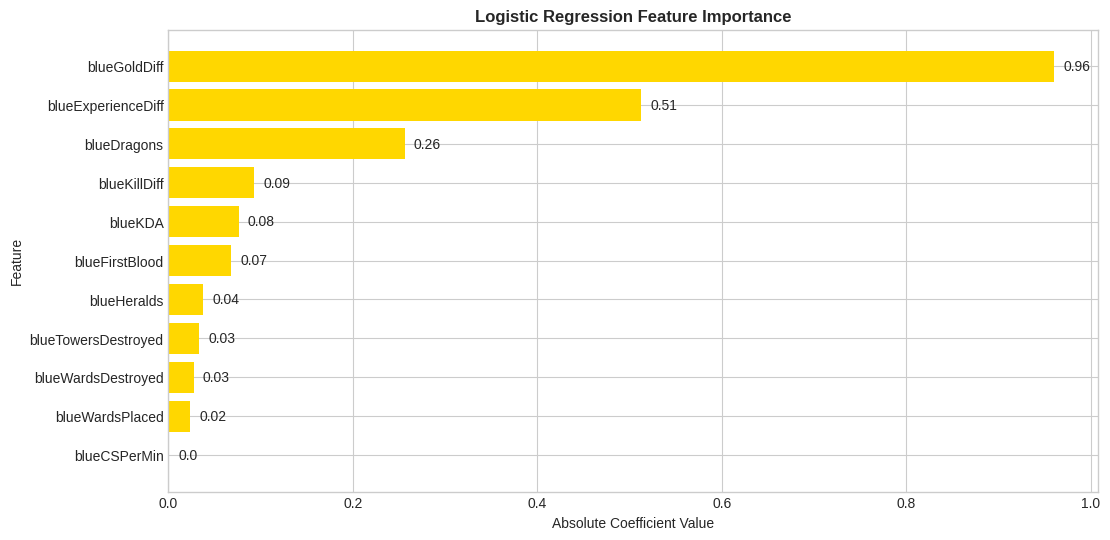

,feature,coef,p_value,abs_coef
x7,blueGoldDiff,0.960162,1.505434e-18,0.960162
x8,blueExperienceDiff,0.512364,6.185612e-14,0.512364
x4,blueDragons,0.255935,9.336043e-19,0.255935
x11,blueKillDiff,-0.092756,3.038147e-01,0.092756
x10,blueKDA,0.076121,2.143402e-01,0.076121
x3,blueFirstBlood,0.068048,2.765197e-02,0.068048
x5,blueHeralds,0.037297,2.053426e-01,0.037297
x6,blueTowersDestroyed,-0.033254,3.873197e-01,0.033254
x2,blueWardsDestroyed,-0.027388,3.459189e-01,0.027388
x1,blueWardsPlaced,-0.023638,4.075274e-01,0.023638


In [55]:
# Logistic Regression Visualization
plt.barh(pval_df['feature'], pval_df['abs_coef'], color='gold')
plt.gca().invert_yaxis()
plt.title('Logistic Regression Feature Importance', fontweight='bold')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')

for i, v in enumerate(pval_df['abs_coef']):
  plt.text(v+0.01, i, round(v, 2), ha='left', va='center')

plt.show()

display(pval_df)

Logistic Regression shows that gold difference is the most significant factor impacting match outcomes. Experience difference ranks second, which is consistent with our earlier conclusion that gold difference and experience difference are strongly correlated. Dragons rank third in terms of importance.

The remaining features are not considered strong factors affecting match outcomes, as their p-values exceed 0.05. Furthermore, their coefficient values drop dramatically.

In [58]:
# Top 3 Common Feature Importance
pval_df_top3 = pval_df.head(3)
rfc_importance_top3 = rfc_importance.head(3)
lgbm_importance_top3 = lgbm_importance.head(3)

display(pval_df_top3)
print('')
display(rfc_importance_top3)
print('')
display(lgbm_importance_top3)

,feature,coef,p_value,abs_coef
x7,blueGoldDiff,0.960162,1.505434e-18,0.960162
x8,blueExperienceDiff,0.512364,6.185612e-14,0.512364
x4,blueDragons,0.255935,9.336043e-19,0.255935


,feature,importance
6,blueGoldDiff,0.366259
7,blueExperienceDiff,0.242284
10,blueKillDiff,0.160306


,feature,importance
6,blueGoldDiff,89226.029136
7,blueExperienceDiff,20632.256441
3,blueDragons,4304.063865


All models proved that gold difference and experience difference are the most significant factors impacting match outcomes.

# **Summary**

## Key Findings

*   Gold Difference : most important feature (coefficient = 0.96)
*   Experience Difference : coefficient = 0.51 / correlation to gold difference = 0.89
*   Dragon : coefficient = 0.26 / win rate = ~22%p ⬆

## Model Performance

*   Best Model : Logistic Regression
*   f1-score : 0.74
*   AUC : 0.82

## Insights

1. Staying in lane without dying for a long period can increase both gold and experience.
2. Strong lane pushing or control is needed at the early game stage.
3. Prioritizing Dragons over Heralds is more reliable for early-game strategy.